It has been suggested by Nick that I can compute a Fischer Forecast with the VDF by just doing finite different around each point in the parameter space. Gonna try to do that here. 

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [14]:
from pearce.emulator import LemonPepperWet, NashvilleHot
import numpy as np
from os import path
import h5py
from copy import deepcopy
from scipy.linalg import inv

In [15]:
peaked=False

In [16]:
training_file ='/u/ki/swmclau2/des/Aemulators/vdf_hsab_box0/PearceHSABVDFBox0.hdf5'
test_file = '/u/ki/swmclau2/des/vdf_hsab_box0_test/PearceHSABVDF.hdf5'
obs='vdf'

In [17]:
fixed_params = {'z':0.0, 'cosmo':0}

In [18]:
fiducial_hod = {'sigma_logM':0.2, 'logM0': 13.0, 'logM1': 14.0,
                'alpha':1.0,'conc_gal_bias': 1.0,\
                'mean_occupation_centrals_assembias_param1': 0.0,
               'mean_occupation_satellites_assembias_param1': 0.0}

In [19]:
np.random.seed(0)
emu = LemonPepperWet(training_file,# hyperparams=hyperparams,\
                     fixed_params = fixed_params,\
                     downsample_factor = 1.0 )

In [20]:
pnames = emu.get_param_names()
pbounds = [emu.get_param_bounds(p) for p in pnames]

In [21]:
pnames

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [22]:
from pearce.mocks.kittens import TrainingBox

In [23]:
cat = TrainingBox(0, system='ki-ls')

In [24]:
cat.load(1.0, HOD='hsabZheng07')

In [25]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl=100) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12,15), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x


In [26]:
add_logMmin(fiducial_hod, cat)

logMmin 13.205627959576999


In [27]:
r_bins = np.logspace(-0.3, 2.0, 21)

In [28]:
def calc_vdf_n_times(N, hod, n_ran=1e6):
#N = 5
    vals = np.zeros((N, len(r_bins)-1))

    for i in xrange(N):
        #print i
        cat.populate(hod)

        vals[i] = cat.calc_vdf(r_bins, n_ran=n_ran)
        
    return vals

In [29]:
def calc_xi_n_times(N, hod):
#N = 5
    vals = np.zeros((N, len(r_bins)-1))

    for i in xrange(N):
        #print i
        cat.populate(hod)

        vals[i] = cat.calc_xi(r_bins)#, n_ran=n_ran)
        
    return vals

In [39]:
N = 100

In [40]:
from time import time
t0 = time()
vdf_vals= calc_vdf_n_times(N, fiducial_hod)
t1 = time()
xi_vals = calc_xi_n_times(N, fiducial_hod)
t2 = time()
print t1-t0, t2-t1

477.390314102 826.992179871


In [41]:
print t1- t0

477.390314102


In [42]:
vdf_covmat = np.cov(vdf_vals, rowvar=False)
vdf_covmat[vdf_covmat==0] = 1e-12
vdf_covmat+=np.diag(np.ones(vdf_covmat.shape[0])*1e-12)

In [43]:
xi_covmat = np.cov(xi_vals, rowvar=False)
#vdf_covmat[covmat==0] = 1e-12
xi_covmat+=np.diag(np.ones(xi_covmat.shape[0])*1e-12)

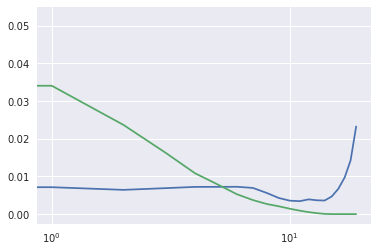

In [44]:
plt.plot(np.sqrt(np.diag(xi_covmat))/np.mean(xi_vals, axis=0))
plt.plot(np.sqrt(np.diag(vdf_covmat))/np.mean(vdf_vals, axis=0))

plt.xscale('log')

In [45]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    denom = np.outer(std, std)
    return cov/denom

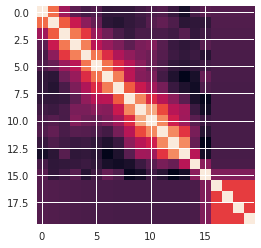

In [46]:
plt.imshow(cov_to_corr(vdf_covmat))

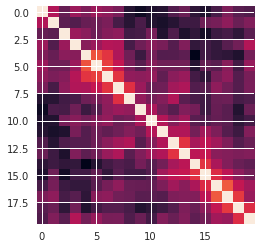

In [47]:
plt.imshow(cov_to_corr(xi_covmat))

In [26]:
inv_vdf_covmat = inv(vdf_covmat)
inv_xi_covmat = inv(xi_covmat)

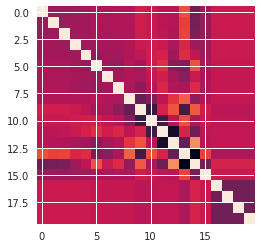

In [27]:
plt.imshow(cov_to_corr(inv_vdf_covmat))

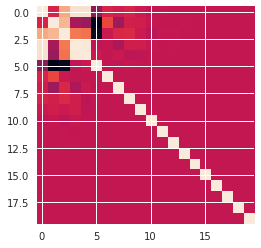

In [28]:
plt.imshow(cov_to_corr(inv_xi_covmat))

In [29]:
fd_vdf_vals = np.zeros((len(pnames), 2, N, len(r_bins)-1))
fd_xi_vals = np.zeros((len(pnames), 2, N, len(r_bins)-1))

step_sizes = np.zeros((len(pnames), ))
for i, (name, bound) in enumerate(zip(pnames, pbounds)):
    hod = deepcopy(fiducial_hod)
    step_size = (bound[1]-bound[0])/10
    vals = (hod[name]-step_size, hod[name]+step_size)
    print name#, step_size
    step_sizes[i] = step_size
    for j,v in enumerate(vals):
        hod[name]=v
        out = calc_vdf_n_times(N, hod)
        
        fd_vdf_vals[i,j] = out
        
        out = calc_xi_n_times(N, hod)
        
        fd_xi_vals[i,j] = out

mean_occupation_centrals_assembias_param1
logM0
sigma_logM
mean_occupation_satellites_assembias_param1
logM1
alpha
conc_gal_bias


In [11]:
pbounds

[(-1.0, 1.0),
 (12.6, 13.6),
 (0.05, 0.5),
 (-1.0, 1.0),
 (13.7, 14.7),
 (0.7, 1.3),
 (0.5, 2.0)]

In [30]:
def deriv(fd_vals, step_sizes):
    avg_vals = fd_vals.mean(axis=2)
    deriv = (avg_vals[:, 1] - avg_vals[:,0]).T/(2*step_sizes)
    return deriv.T

In [31]:
d_vdf = deriv(fd_vdf_vals, step_sizes)
d_xi = deriv(fd_xi_vals, step_sizes)

In [12]:
emu.scale_bin_centers

array([ 0.57715889,  0.7521343 ,  0.98015643,  1.27730729,  1.66454443,
        2.16917901,  2.82680202,  3.68379447,  4.80059857,  6.25598058,
        8.15258606, 10.62417931, 13.84507753, 18.04244507, 23.51231502,
       30.64046783, 39.92963975, 52.03497999, 67.81025724, 88.36807447])

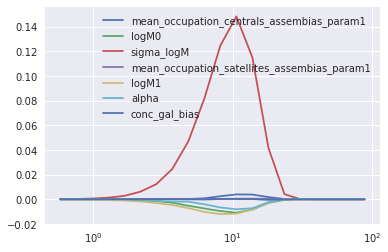

In [32]:
for i, name in enumerate(pnames):
    plt.plot(emu.scale_bin_centers, d_vdf[i], label = name)
plt.legend(loc='best')
plt.xscale('log')

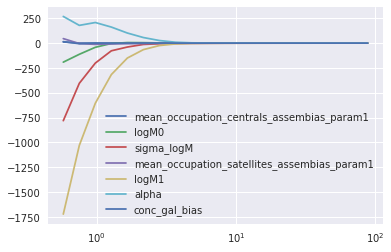

In [33]:
for i, name in enumerate(pnames):
    plt.plot(emu.scale_bin_centers, d_xi[i], label = name)
plt.legend(loc='best')
plt.xscale('log')

In [34]:
vdf_fischer_mat = np.dot(d_vdf, np.dot(inv_vdf_covmat, d_vdf.T))
xi_fischer_mat = np.dot(d_xi, np.dot(inv_xi_covmat, d_xi.T))

In [35]:
vdf_info_mat = inv(vdf_fischer_mat)
xi_info_mat = inv(xi_fischer_mat)

In [46]:
from matplotlib.patches import Ellipse
def ellipse_plot(inv_fisher, mean_x, mean_y, xname, yname, fig, ax, co):
    #alpha paramaters for 1 and 2 sigma contours
    alpha1 = 1.52
    alpha2 = 2.48
    #extracting relevant params from the input inverse fisher matrix
    sigma_x2 = inv_fisher[0][0]
    sigma_y2 = inv_fisher[1][1]
    sigma_xy = inv_fisher[0][1]
    #building a^2 and b^2 for the ellipse
    a2 = (sigma_x2 + sigma_y2)/2. + np.sqrt((sigma_x2 - sigma_y2)**2/4. + sigma_xy**2)
    b2 = (sigma_x2 + sigma_y2)/2. - np.sqrt((sigma_x2 - sigma_y2)**2/4. + sigma_xy**2)
    #print a2, b2
    #tilt angle
    tan2theta = 2.*(sigma_xy)/(sigma_x2 - sigma_y2)
    ang = -0.5*np.arctan(tan2theta)
    #print ang
    #plotting 1 and 2 sigma contours
    ell = Ellipse(xy = [mean_x, mean_y], height = alpha1*np.sqrt(a2), width = alpha1*np.sqrt(b2), angle = np.degrees(ang), alpha=0.5, fill=True, color=co)
    ell2 = Ellipse(xy = [mean_x, mean_y], height = alpha2*np.sqrt(a2), width = alpha2*np.sqrt(b2), angle = np.degrees(ang), alpha=0.35, fill=True,  color=co)
    #adding patches, axis names, etc
    ax.add_patch(ell)
    ax.add_patch(ell2)
    #ax.set_aspect('equal')
    ax.autoscale()
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)

In [1]:
size = len(pnames)*3
fig, axes = plt.subplots(ncols=len(pnames)-1, nrows=len(pnames)-1, figsize=((size,size)))
bool_slice = np.zeros_like(xi_info_mat).astype(bool)

for i, name1 in enumerate(pnames):

    for j, name2 in enumerate(pnames[:i]):
        ellipse_plot(vdf_info_mat[np.ix_([i,j],[i,j])], fiducial_hod[name1], fiducial_hod[name2], name1, name2, fig, axes[j][i-1], co = 'b')
        ellipse_plot(1e6*xi_info_mat[np.ix_([i,j],[i,j])], fiducial_hod[name1], fiducial_hod[name2], name1, name2, fig, axes[j][i-1], co = 'r')


NameError: name 'pnames' is not defined